In [1]:
import time
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import datetime
import matplotlib.dates as mdates
from collections import deque
import numpy as np

import serial
import re

PORT = "COM6"

# How many sensor samples we want to store
HISTORY_SIZE = 2500

# Pause re-sampling the sensor and drawing for INTERVAL seconds
INTERVAL = 0.01


In [2]:
serialport = None

def get_imu_data():
    global serialport
    if not serialport:
        # open serial port
        serialport = serial.Serial(PORT, 115200, timeout=0.1)
        # check which port was really used
        print("Opened", serialport.name)
        # Flush input
        time.sleep(3)
        serialport.readline()

    # Poll the serial port
    line = str(serialport.readline(), 'utf-8')
    if not line:
        return None
    #print(line)
    if not "Uni:" in line:
        return None
    vals = line.replace("Uni:", "").strip().split(',')
    #print(vals)
    if len(vals) != 9:
        return None
    try:
        vals = [float(i) for i in vals]
    except ValueError:
        return None
    #print(vals)
    return vals

for _ in range(20):
    print(get_imu_data())

Opened COM6
None
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 828.02, 105.88, -40.13]
None
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 828.02, 105.88, -40.13]
None
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 823.2, 96.25, -32.6]
None
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 823.2, 96.25, -32.6]
None
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 830.44, 96.25, -37.62]
None
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 830.44, 96.25, -37.62]
None
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 815.95, 110.69, -47.65]
None
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 815.95, 110.69, -47.65]
None
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 828.02, 110.69, -40.13]
None
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 828.02, 110.69, -40.13]


# Magnetometer data capture

<IPython.core.display.Javascript object>


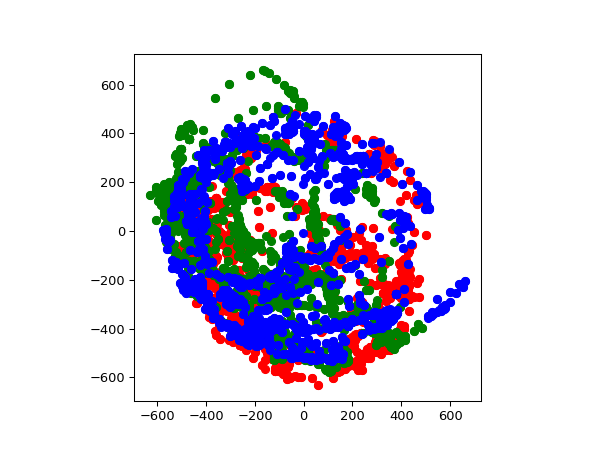

In [8]:
# Deque for axes
mag_x = deque(maxlen=HISTORY_SIZE)
mag_y = deque(maxlen=HISTORY_SIZE)
mag_z = deque(maxlen=HISTORY_SIZE)

fig, ax = plt.subplots(1, 1)
ax.set_aspect(1)

# close port in case its open
if serialport:
    try:
        serialport.close()
    except NameError:
        pass

serialport = None
anim = None

def onClick(event):
    anim.event_source.stop()
    
def animate(i):
    for _ in range(30):
        ret = get_imu_data()
        if not ret:
            continue
        x, y, z = ret[6:9]
        mag_x.append(x)
        mag_y.append(y)
        mag_z.append(z)

    # Clear all axis
    ax.cla()

    # Display the sub-plots
    ax.scatter(mag_x, mag_y, color='r')
    ax.scatter(mag_y, mag_z, color='g')
    ax.scatter(mag_z, mag_x, color='b')
    
    if len(mag_x) == HISTORY_SIZE:
        anim.event_source.stop()
    # Pause the plot for INTERVAL seconds 
    plt.pause(INTERVAL)

fig.canvas.mpl_connect('button_press_event', onClick)    
anim = FuncAnimation(fig, animate)

X range:  -531.7 500.31
Y range:  -630.44 483.66
Z range:  -577.42 661.44
Final calibration in uTesla: [-15.695000000000022, -73.39000000000001, 42.01000000000005]


<IPython.core.display.Javascript object>


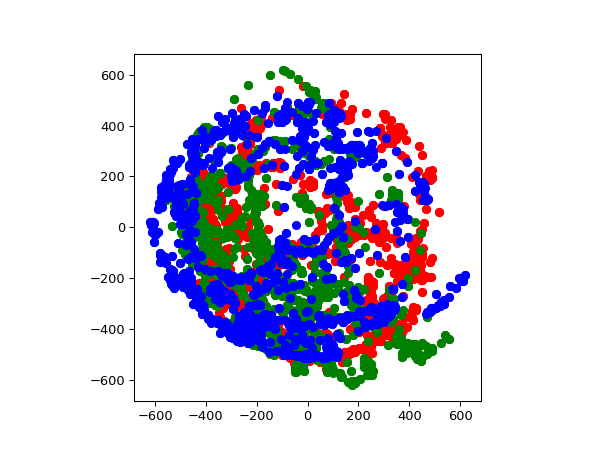

In [9]:
min_x = min(mag_x)
max_x = max(mag_x)
min_y = min(mag_y)
max_y = max(mag_y)
min_z = min(mag_z)
max_z = max(mag_z)

print("X range: ", min_x, max_x)
print("Y range: ", min_y, max_y)
print("Z range: ", min_z, max_z)

mag_calibration = [ (max_x + min_x) / 2, (max_y + min_y) / 2, (max_z + min_z) / 2]
print("Final calibration in uTesla:", mag_calibration)

cal_mag_x = [x - mag_calibration[0] for x in mag_x]
cal_mag_y = [y - mag_calibration[1] for y in mag_y]
cal_mag_z = [z - mag_calibration[2] for z in mag_z]

fig, ax = plt.subplots(1, 1)
ax.set_aspect(1)

# Clear all axis
ax.cla()

# Display the now calibrated data
ax.scatter(cal_mag_x, cal_mag_y, color='r')
ax.scatter(cal_mag_y, cal_mag_z, color='g')
ax.scatter(cal_mag_z, cal_mag_x, color='b')
fig.show()